# 다중회귀 분석

In [4]:
import pandas as pd

#!pip install datetime
#!pip install sklearn
#!pip install scipy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
data = pd.read_excel('data/final_data.xlsx')

In [12]:
data = data.set_index('year_month')

In [14]:
# 1개월 시간차 데이터 생성
data['RAV4 Sales'] = data['RAV4 Sales'].shift(-1)
data = data.dropna()

In [16]:
=data.head()

,RAV4 Sales,Federal Funds Effective Rate,sentiment_prediction,Consumer_Interest,Competitor_Sales,Price_Factor
year_month,,,,,,
2010-01,6799.0,0.11,1.0,-0.452485,3.869561,-0.592358
2010-02,25781.0,0.13,1.0,-0.495998,3.995724,-0.511696
2010-03,14851.0,0.16,1.0,-0.380068,2.875564,-0.656660
2010-04,13102.0,0.20,1.0,-0.419988,2.895012,-0.743742
2010-05,12573.0,0.20,1.0,-0.467016,2.524651,-0.730052


## 1. EDA 시각화

In [19]:
# 독립변수 리스트
independent_vars = ["Federal Funds Effective Rate", "sentiment_prediction", "Consumer_Interest", "Competitor_Sales", "Price_Factor"]

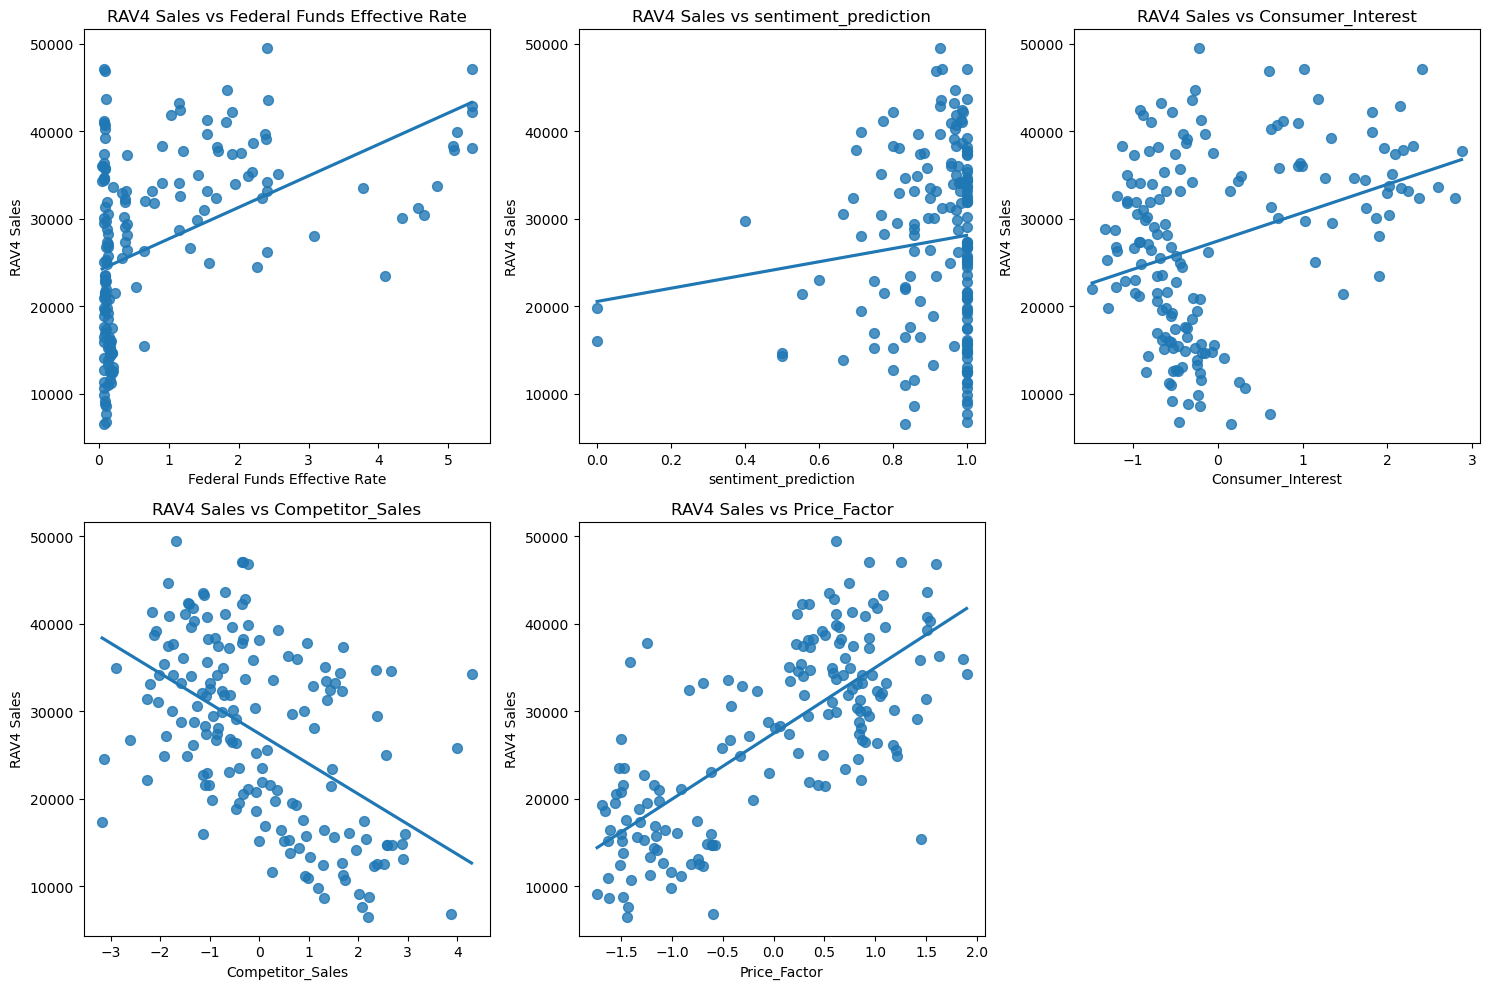

In [21]:
# 산점도 그리기
plt.figure(figsize=(15, 10))
for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 3, i)
    sns.regplot(x=data[var], y=data["RAV4 Sales"], ci=None, scatter_kws={'s': 50})
    plt.title(f'RAV4 Sales vs {var}')
    plt.xlabel(var)
    plt.ylabel('RAV4 Sales')

plt.tight_layout()
plt.show()

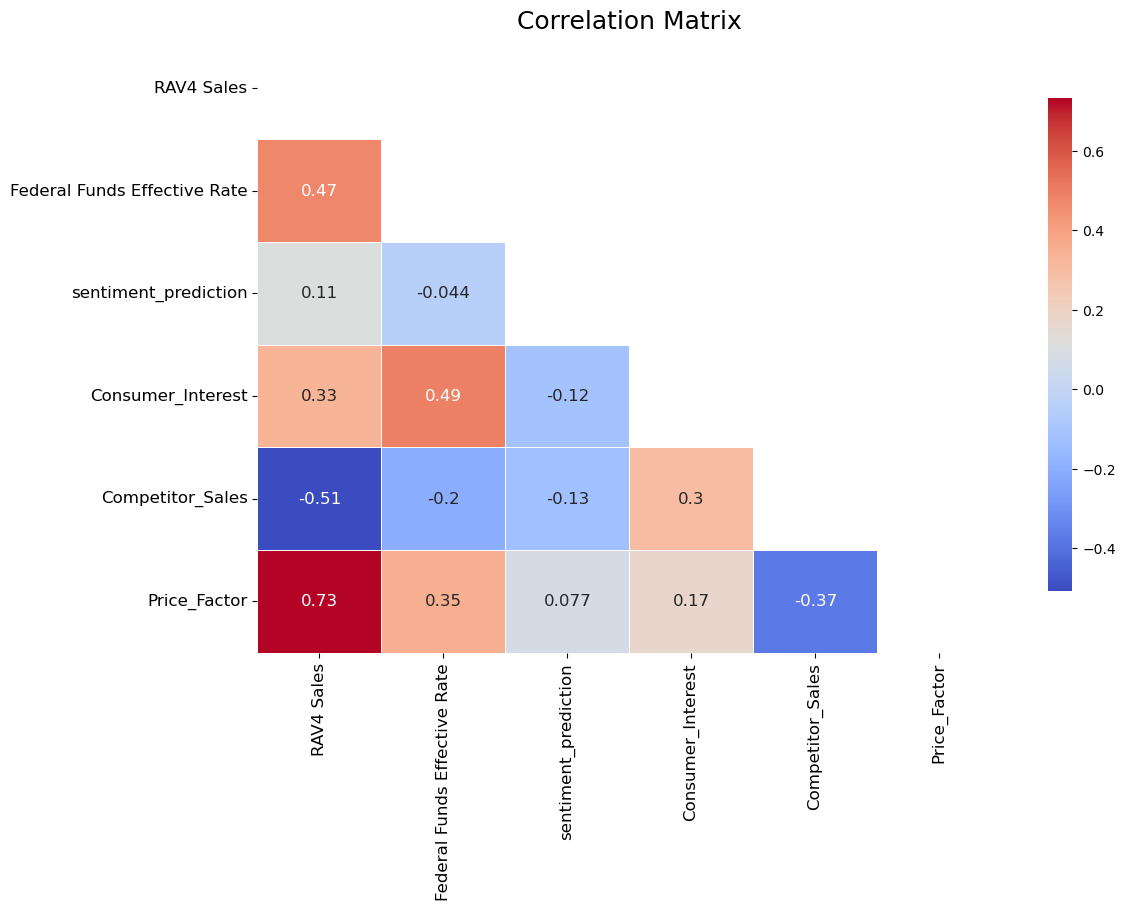

In [25]:
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()

# 상삼각 부분을 회색으로 설정
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 히트맵 그리기
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, cbar_kws={"shrink": .8},
            annot_kws={"size": 12}, linewidths=.5)

plt.title('Correlation Matrix', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

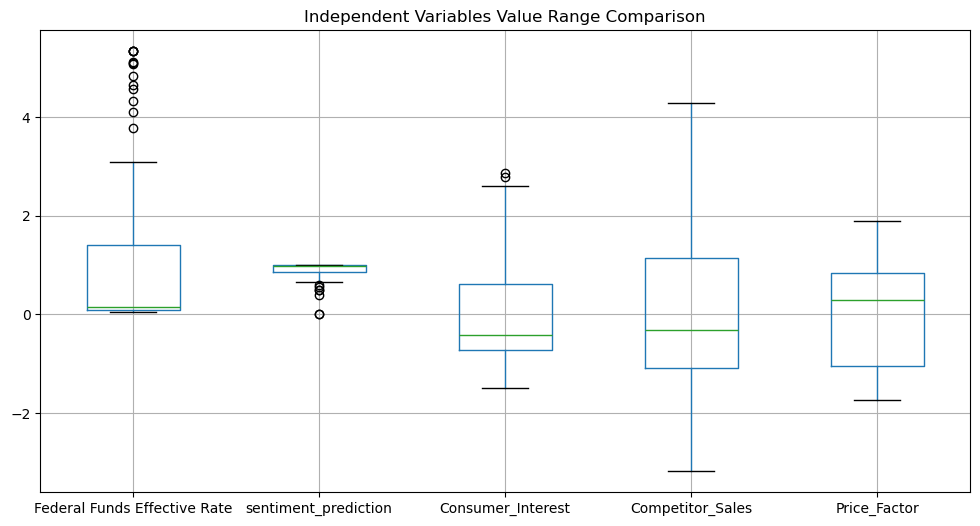

In [27]:
# 독립변수들의 값 범위 비교
plt.figure(figsize=(12, 6))
data.drop(columns=['RAV4 Sales']).boxplot()
plt.title('Independent Variables Value Range Comparison')
plt.show()

독립변수들의 값 범위가 상이함
- Federal Funds Effective Rate : 0~4
- sentiment_prediction : -2 ~2

=> 변수간의 균형을 맞추기 위해 표준화 진행

## 2. 변수 표준화 

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [35]:
# 독립변수와 종속변수 분리
X = data.drop(columns=['RAV4 Sales'])
y = data['RAV4 Sales']

In [37]:
# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [39]:
# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

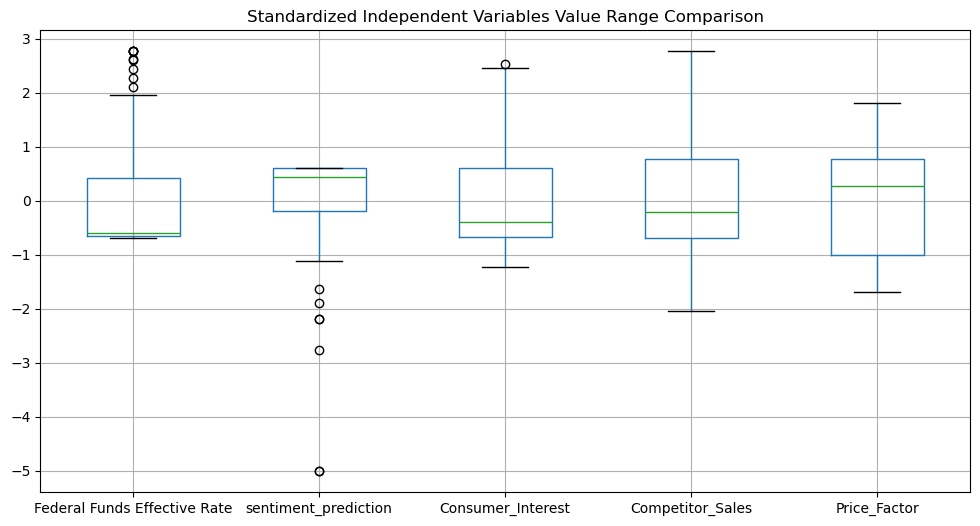

In [41]:
# 표준화된 데이터를 데이터프레임으로 변환
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# 표준화된 데이터의 박스플롯 그리기
plt.figure(figsize=(12, 6))
X_train_scaled_df.boxplot()
plt.title('Standardized Independent Variables Value Range Comparison')
plt.show()

In [43]:
# 다중선형회귀모델 학습
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [45]:
# 검증세트 평가
y_val_pred = model.predict(X_val_scaled)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f'검증 세트 RMSE: {val_rmse}')
print(f'검증 세트 R2: {val_r2}')

검증 세트 RMSE: 5446.28514321781
검증 세트 R2: 0.7426409093639699


## 3. 결과 해석
- RSME : 예측한 값과 실제 값 사이의 평균적인 차이
- R-squared : 모델이 데이터를 얼마나 잘 설명하는지 (1에 가까울 수록 모델이 데이터를 잘 섦여함)


---
=> R-squared 값이 0.736로 높은 설명력을 가지는 모델임을 의미함


In [48]:
# 다양한 회귀 모델 비교
import itertools
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [50]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Regressor': SVR()
}

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [54]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2
    })

In [56]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE')
#값 소수점 3자리까지만
results_df['MSE'] = results_df['MSE'].apply(lambda x: round(x, 3))
results_df['RMSE'] = results_df['RMSE'].apply(lambda x: round(x, 3))
results_df['MAE'] = results_df['MAE'].apply(lambda x: round(x, 3))
results_df['R-squared'] = results_df['R-squared'].apply(lambda x: round(x, 3))

In [58]:
print(results_df)


                      Model           MSE       RMSE       MAE  R-squared
3             Random Forest  2.647479e+07   5145.366  4034.784      0.770
1          Ridge Regression  2.956134e+07   5437.034  4248.548      0.744
2          Lasso Regression  2.965996e+07   5446.096  4249.502      0.743
0         Linear Regression  2.966202e+07   5446.285  4249.488      0.743
4  Support Vector Regressor  1.276601e+08  11298.678  9305.622     -0.108


In [60]:
#랜덤 포레스트 중요도
rf_model = models['Random Forest']
rf_model.fit(X_train_scaled, y_train)
feature_importances = rf_model.feature_importances_

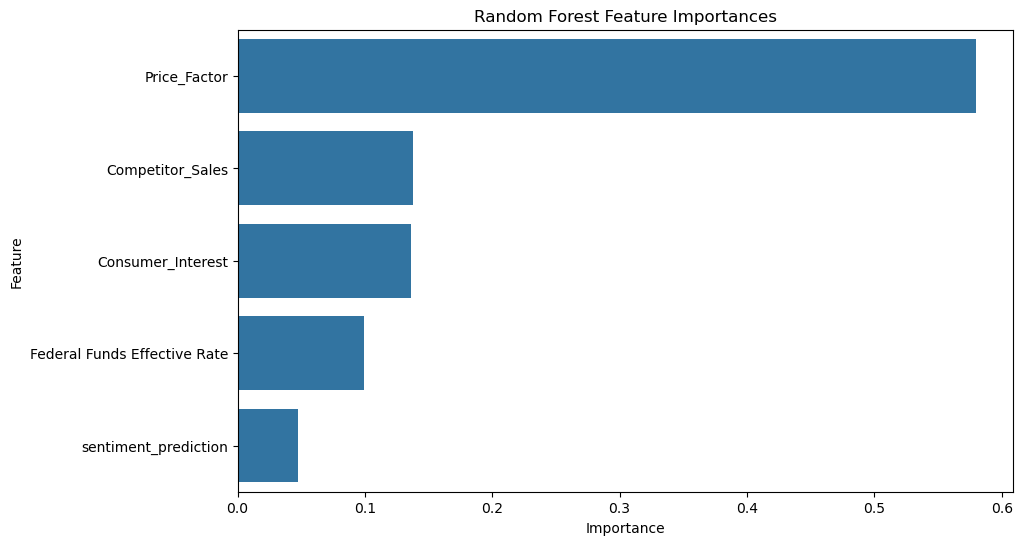

In [66]:
# 랜덤 포레스트 변수 중요도 시각화
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Random Forest Feature Importances')
plt.show()

In [68]:
feature_importance_df

,Feature,Importance
4,Price_Factor,0.579628
3,Competitor_Sales,0.137869
2,Consumer_Interest,0.135780
0,Federal Funds Effective Rate,0.099211
1,sentiment_prediction,0.047512


- 주요 예측 변수 : 가격 요인
- 소비자의 리뷰 긍/부정(sentiment_prediction)은 자동차 판매량에 영향을 끼치는 변수 중 가장 낮은 중요도를 보임

**=> 소비자 감성은 자동차 판매량을 예측하는 주요요인으로 고려되지 않음**



---



## 4. 시행착오 부분


### 4.1 OLS

In [73]:
# OLS 회귀 분석
X_train_ols = sm.add_constant(X_train_scaled)  # 상수항 추가
X_test_ols = sm.add_constant(X_test_scaled)  # 상수항 추가
ols_model = sm.OLS(y_train, X_train_ols).fit()

In [75]:
# OLS 결과 출력
print(ols_model.summary())

# 예측 및 평가 (OLS)
y_test_pred_ols = ols_model.predict(X_test_ols)
test_rmse_ols = np.sqrt(mean_squared_error(y_test, y_test_pred_ols))
test_r2_ols = r2_score(y_test, y_test_pred_ols)

print(f'OLS 테스트 세트 RMSE: {test_rmse_ols}')
print(f'OLS 테스트 세트 R2: {test_r2_ols}')


                            OLS Regression Results                            
Dep. Variable:             RAV4 Sales   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     40.79
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           4.09e-22
Time:                        14:37:44   Log-Likelihood:                -1010.0
No. Observations:                 100   AIC:                             2032.
Df Residuals:                      94   BIC:                             2048.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.836e+04    607.530     46.686      0.0

### 4.2 GLS

In [78]:
# GLS 회귀 분석
gls_model = sm.GLS(y_train, X_train_ols).fit()

# GLS 결과 출력
print(gls_model.summary())

# 예측 및 평가 (GLS)
y_test_pred_gls = gls_model.predict(X_test_ols)
test_rmse_gls = np.sqrt(mean_squared_error(y_test, y_test_pred_gls))
test_r2_gls = r2_score(y_test, y_test_pred_gls)

print(f'GLS 테스트 세트 RMSE: {test_rmse_gls}')
print(f'GLS 테스트 세트 R2: {test_r2_gls}')

                            GLS Regression Results                            
Dep. Variable:             RAV4 Sales   R-squared:                       0.685
Model:                            GLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     40.79
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           4.09e-22
Time:                        14:37:45   Log-Likelihood:                -1010.0
No. Observations:                 100   AIC:                             2032.
Df Residuals:                      94   BIC:                             2048.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.836e+04    607.530     46.686      0.0

Random Forest: 가장 낮은 RMSE (4467.34)와 가장 높은 R² (0.826845)를 기록하여, RAV4 Sales 예측에 가장 적합한 모델임을 확인할 수 있습니다.

Ridge, Lasso, Linear Regression: 세 모델은 유사한 성능을 보이며, 데이터의 변동성을 잘 설명합니다.

Support Vector Regressor (SVR): 매우 높은 RMSE (11298.90)와 음수의 R² (-0.107671) 값을 기록하여, 예측에 적합하지 않은 모델임을 확인할 수 있습니다.

=> Random Fores 모델이 가장 적합한 모델임

### <OLS, GLS 분석결과 요약>

**OLS (Ordinary Least Squares) Regression**
- R² (훈련 세트): 0.733
- 조정된 R²: 0.706
- F-statistic: 27.45 (p-value: 3.36e-22)
- 테스트 세트 RMSE: 3698.49
- 테스트 세트 R²: 0.8419


**GLS (Generalized Least Squares) Regression**
- R² (훈련 세트): 0.733
- 조정된 R²: 0.706
- F-statistic: 27.45 (p-value: 3.36e-22)
- 테스트 세트 RMSE: 3698.49
- 테스트 세트 R²: 0.8419

=> 값이 매우 유사함
=> R-squared 높은 값으로 예측정확도 높음